# Trying to train UNet with L1 loss

In [1]:
dataset = "data/Coco"
version = "2017"

In [2]:
import torch
import torch.utils.data as data
from python.data.dataset import *
from python.models.generator import UNet
from python.models.discriminator import PatchGAN
from python.utils.images import *
from python.train.trainer import *
from tqdm.notebook import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
dataset_train = CocoLab_cpu(dataset, version=version, size=256, train=True)
trainloader = data.DataLoader(dataset_train, batch_size=1, shuffle=True, num_workers=2)

dataset_test = CocoLab_cpu(dataset, version=version, size=256, train=False)
testloader = data.DataLoader(dataset_test, batch_size=1, shuffle=True, num_workers=2)

generator = UNet(1, 2).to(device)
discriminator = PatchGAN(3).to(device)

torch.Size([1, 3, 256, 256])


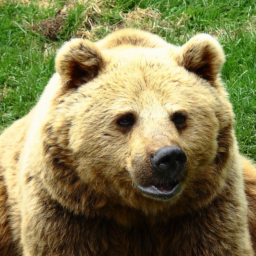

In [4]:
# one image from the training set
L_base, ab_base = next(iter(trainloader))

Lab = torch.concat((L_base, ab_base), 1)
print(Lab.shape)
tensor_to_pil(Lab)[0]

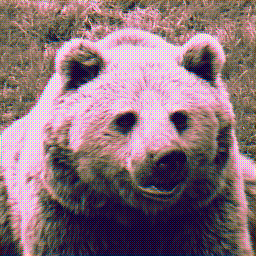

In [5]:
# trying the prediction of the Unet before training
generator.eval()
L_base = L_base.to(device)
ab_pred_notrain = generator(L_base).detach()
Lab_pred_notrain = torch.concat((L_base, ab_pred_notrain), 1).to("cpu")
tensor_to_pil(Lab_pred_notrain)[0]

In [6]:
num_epochs = 100

In [ ]:
gan_train = GanTrain(generator, discriminator)

train_g_avg_loss = []
train_d_avg_loss = []
test_g_avg_loss = []
test_d_avg_loss = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for epoch in range(num_epochs):
    train_g_losses = []
    train_d_losses = []
    test_g_losses = []
    test_d_losses = []
    
    with tqdm(trainloader, unit="batch") as tepoch:
        for L, ab in tepoch:
            tepoch.set_description(f"Epoch {epoch}")
            L = L.to(device)
            ab = ab.to(device)

            g_loss, d_loss = gan_train.step(L, ab, reg_R1=False)

            train_g_losses.append(g_loss.detach())
            train_d_losses.append(d_loss.detach())        

        with torch.no_grad():   
            # Do not set .eval()
            for L, ab in testloader:
                L = L.to(device)
                ab = ab.to(device)
                fake_ab = generator(L)
                g_loss = gan_train.generator_loss(L, ab, fake_ab)
                d_loss = gan_train.discriminator_loss(L, ab, fake_ab)
                
                train_g_losses.append(g_loss.detach())
                train_d_losses.append(d_loss.detach()) 

            train_g_avg_loss.append(torch.mean(torch.Tensor(train_g_losses)))
            train_d_avg_loss.append(torch.mean(torch.Tensor(train_d_losses)))
            test_g_avg_loss.append(torch.mean(torch.Tensor(test_g_losses)))
            test_d_avg_loss.append(torch.mean(torch.Tensor(test_d_losses)))
            
            print('[Epoch {}/{}] '.format(epoch+1, num_epochs) + "\n\t--- Generator ---\n"
                    '\ttrain_loss: {:.4f} - '.format(train_g_avg_loss[-1]) +
                    'test_loss: {:.4f} - '.format(test_g_avg_loss[-1]) + "\n\t--- Discriminator ---\n"
                    'train_loss: {:.4f} - '.format(train_d_avg_loss[-1]) +
                    'test_loss: {:.4f}'.format(test_d_avg_loss[-1]))

            ab_pred = generator(L_base).detach()
            Lab_pred = torch.concat((L_base, ab_pred), 1).to("cpu")
            if epoch%5==0:
                tensor_to_pil(Lab_pred)[0].save("epoch_{}.png".format(epoch))
            #torch.save(generator.state_dict(), "saved_models/generator")

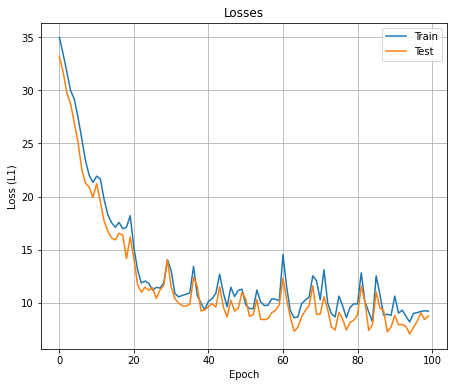

In [8]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.title('Losses')
plt.plot(train_d_avg_loss)
plt.plot(test_d_avg_loss)
plt.grid()
plt.legend(['Train', 'Test'])
plt.xlabel('Epoch')
plt.ylabel('Loss (L1)')


plt.show()

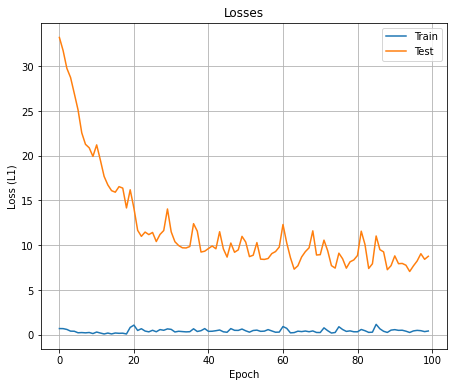

In [9]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.title('Losses')
plt.plot(train_g_avg_loss)
plt.plot(test_g_avg_loss)
plt.grid()
plt.legend(['Train', 'Test'])
plt.xlabel('Epoch')
plt.ylabel('Loss (L1)')


plt.show()

In [10]:
# trying the prediction of the Unet after training
generator.eval()
ab_pred_train = generator(L).detach()
Lab_pred_train = torch.concat((L, ab_pred_train), 1).to("cpu")

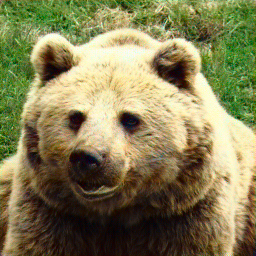

In [11]:
tensor_to_pil(Lab_pred_train)[0]

>R1 

In [7]:
gan_train = GanTrain(generator, discriminator)

train_g_avg_loss = []
train_d_avg_loss = []
test_g_avg_loss = []
test_d_avg_loss = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for epoch in range(num_epochs):
    train_g_losses = []
    train_d_losses = []
    test_g_losses = []
    test_d_losses = []
    
    with tqdm(trainloader, unit="batch") as tepoch:
        for L, ab in tepoch:
            tepoch.set_description(f"Epoch {epoch}")
            L = L.to(device)
            ab = ab.to(device)

            g_loss, d_loss = gan_train.step(L, ab, reg_R1=True)

            train_g_losses.append(g_loss.detach())
            train_d_losses.append(d_loss.detach())        

        with torch.no_grad():   
            # Do not set .eval()
            for L, ab in testloader:
                L = L.to(device)
                ab = ab.to(device)
                fake_ab = generator(L)
                g_loss = gan_train.generator_loss(L, ab, fake_ab)
                d_loss = gan_train.discriminator_loss(L, ab, fake_ab)
                
                train_g_losses.append(g_loss.detach())
                train_d_losses.append(d_loss.detach()) 

            train_g_avg_loss.append(torch.mean(torch.Tensor(train_g_losses)))
            train_d_avg_loss.append(torch.mean(torch.Tensor(train_d_losses)))
            test_g_avg_loss.append(torch.mean(torch.Tensor(test_g_losses)))
            test_d_avg_loss.append(torch.mean(torch.Tensor(test_d_losses)))

            print('[Epoch {}/{}] '.format(epoch+1, num_epochs) + "\n\t--- Generator ---\n"
                    '\ttrain_loss: {:.4f} - '.format(train_g_avg_loss[-1]) +
                    'test_loss: {:.4f} - '.format(test_g_avg_loss[-1]) + "\n\t--- Discriminator ---\n"
                    'train_loss: {:.4f} - '.format(train_d_avg_loss[-1]) +
                    'test_loss: {:.4f}'.format(test_d_avg_loss[-1]))

            ab_pred = generator(L_base).detach()
            Lab_pred = torch.concat((L_base, ab_pred), 1).to("cpu")
            if epoch%5==0:
                tensor_to_pil(Lab_pred)[0].save("R1_epoch_{}.png".format(epoch))
            #torch.save(generator.state_dict(), "saved_models/generator")

  0%|          | 0/1 [00:00<?, ?batch/s]

RuntimeError: One of the differentiated Tensors does not require grad

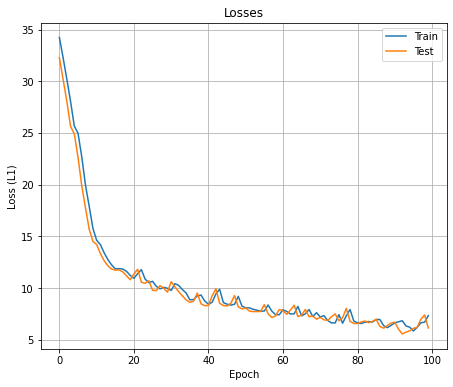

In [20]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.title('Losses')
plt.plot(train_d_avg_loss)
plt.plot(test_d_avg_loss)
plt.grid()
plt.legend(['Train', 'Test'])
plt.xlabel('Epoch')
plt.ylabel('Loss (L1)')


plt.show()

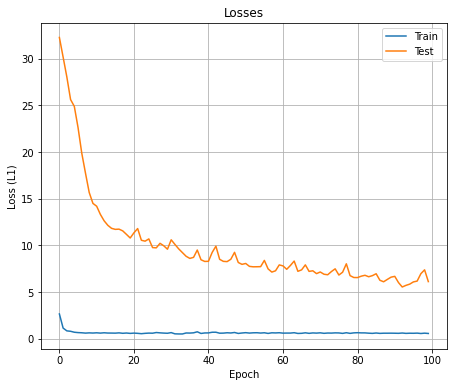

In [21]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.title('Losses')
plt.plot(train_g_avg_loss)
plt.plot(test_g_avg_loss)
plt.grid()
plt.legend(['Train', 'Test'])
plt.xlabel('Epoch')
plt.ylabel('Loss (L1)')


plt.show()